<a href="https://colab.research.google.com/github/LeSaUi/DLtest/blob/main/nlp_from_scratch_classifying_names_with_a_character_level_rnn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2023-07-06 14:51:57--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.227.254.95, 13.227.254.35, 13.227.254.15, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.227.254.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.02s   

2023-07-06 14:51:57 (153 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ita

In [3]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

print('U2A example: Ślusàrski -> ',unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print('num letter',n_letters)
print('all category',all_categories)
print('num category',n_categories)

['data/names/Italian.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Polish.txt']
U2A example: Ślusàrski ->  Slusarski
num letter 57
all category ['Italian', 'French', 'German', 'Vietnamese', 'Scottish', 'Arabic', 'Korean', 'Spanish', 'Portuguese', 'Greek', 'Dutch', 'Japanese', 'Irish', 'Chinese', 'Russian', 'English', 'Czech', 'Polish']
num category 18


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
import torch

# find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
  return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [6]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(input)
print(output)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [9]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 16)


In [10]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '\ line =', line)

category = French \ line = Eustis
category = English \ line = Garvey
category = Arabic \ line = Kouri
category = French \ line = Bonnet
category = French \ line = Beaulieu
category = French \ line = Michaud
category = Chinese \ line = Ruan
category = Dutch \ line = Dale
category = German \ line = Wolf
category = Greek \ line = Demetrious


In [11]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Add parameters' gradients to their values, multiplied by learning rate
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()


In [13]:
import time

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = s // 60
  s %= 60
  return f'{m}m {s}s'

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # Print ''iter'' number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'O' if guess == category else f'X (truth : {category})'
    print(f'[{iter} {iter / n_iters * 100}%] (time {timeSince(start)}s) (loss {loss:.4f}) (input: {line} / output: {guess}) {correct}')

  # Add current loss avg to list of losses
  if iter % plot_every == 0:
    all_losses += [current_loss / plot_every]
    current_loss = 0


[5000 5.0%] (time 0.0m 7.675155401229858ss) (loss 2.5538) (input: Fonseca / output: Portuguese) O
[10000 10.0%] (time 0.0m 15.197338104248047ss) (loss 2.5299) (input: Harb / output: Vietnamese) X (truth : Arabic)
[15000 15.0%] (time 0.0m 22.794349431991577ss) (loss 0.5910) (input: Kosmas / output: Greek) O
[20000 20.0%] (time 0.0m 29.512284517288208ss) (loss 1.1630) (input: Delgado / output: Italian) X (truth : Portuguese)
[25000 25.0%] (time 0.0m 37.03170871734619ss) (loss 0.7369) (input: Puerta / output: Spanish) O
[30000 30.0%] (time 0.0m 44.36709713935852ss) (loss 6.0094) (input: Valters / output: Dutch) X (truth : Russian)
[35000 35.0%] (time 0.0m 51.41384530067444ss) (loss 0.5168) (input: Amoretto / output: Italian) O
[40000 40.0%] (time 0.0m 59.09362602233887ss) (loss 1.0226) (input: Reiher / output: German) O
[45000 45.0%] (time 1.0m 5.712969541549683ss) (loss 4.2785) (input: Kessler / output: German) X (truth : Czech)
[50000 50.0%] (time 1.0m 13.27442193031311ss) (loss 2.8540)

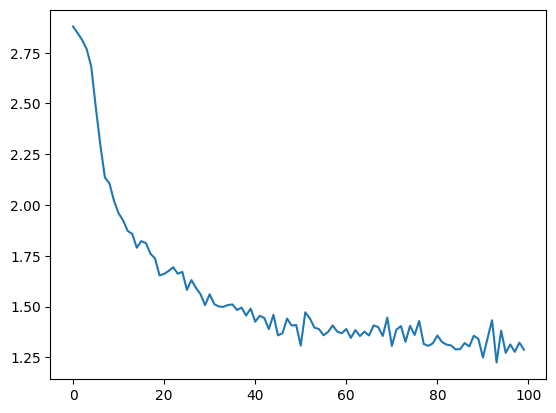

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

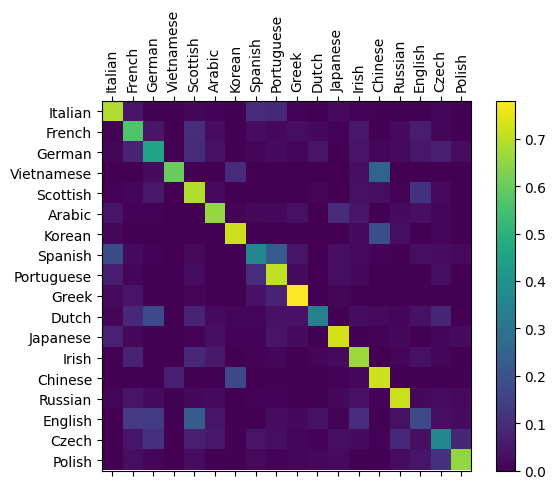

In [31]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(n_categories))
ax.set_xticklabels(all_categories, rotation=90)

ax.set_yticks(range(n_categories))
ax.set_yticklabels(all_categories)


# equal to above but why we do this?
#ax.set_xticklabels([''] + all_categories, rotation=90)
#ax.set_yticklabels([''] + all_categories)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [34]:
def predict(input_line, n_predictions=3):
  print(f'\n> {input_line}')
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print(f'({value:.2f}) {all_categories[category_index]}')
      predictions += [value, all_categories[category_index]]

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.38) Russian
(-1.47) Czech
(-3.29) English

> Jackson
(-0.52) Scottish
(-1.72) Russian
(-2.44) English

> Satoshi
(-0.61) Italian
(-1.89) Arabic
(-2.10) Japanese
